In [1]:
from abc import ABC, abstractmethod
from loguru import logger
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

class Bandit(ABC):
    #@abstractmethod
    def __init__(self, p):
        """
        Initialize the EpsilonGreedy arm.

        Parameters:
        p (float): The win rate of the arm.
        """
        self.p = p
        self.p_estimate = 0 #estimate of average reward
        self.N = 0
        self.r_estimate = 0 #estimate of average regret

    #@abstractmethod
    def __repr__(self):
        
        return f'An Arm with {self.p} Win Rate'

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    #@abstractmethod
    def report(self, N, results, algorithm = "Epsilon Greedy"):
        
        if algorithm == 'EpsilonGreedy':
            cumulative_reward_average, cumulative_reward,  cumulative_regret, bandits, chosen_bandit, reward, count_suboptimal = results 
        else:
            cumulative_reward_average, cumulative_reward,  cumulative_regret, bandits, chosen_bandit, reward = results 
        
        # Save experiment data to a CSV file
        data_df = pd.DataFrame({
            'Bandit': [b for b in chosen_bandit],
            'Reward': [r for r in reward],
            'Algorithm': algorithm
        })

        data_df.to_csv(f'{algorithm}_Experiment.csv', index=False)

        # Save Final Results to a CSV file
        data_df1 = pd.DataFrame({
            'Bandit': [b for b in bandits],
            'Reward': [p.p_estimate for p in bandits],
            'Algorithm': algorithm
        })


        data_df1.to_csv(f'{algorithm}_Final.csv', index=False)

        for b in range(len(bandits)):
            print(f'Bandit with True Win Rate {bandits[b].p} - Pulled {bandits[b].N} times - Estimated average reward - {round(bandits[b].p_estimate, 4)} - Estimated average regret - {round(bandits[b].r_estimate, 4)}')
        
        
        print(f"Cumulative Reward : {sum(reward)}")
        
        print(" ")
        
        print(f"Cumulative Regret : {cumulative_regret[-1]}")
              
        print(" ")
        
        if algorithm == 'EpsilonGreedy':                            
            print(f"Percent suboptimal : {round((float(count_suboptimal) / N), 4)}")

class Visualization:
    def plot1(self, N, results, algorithm='Epsilon Greedy'): 
        cumulative_reward_average = results[0]
        bandits = results[3]
        
        ## LINEAR SCALE
        plt.plot(cumulative_reward_average, label='Cumulative Average Reward')
        plt.plot(np.ones(N) * max([b.p for b in bandits]), label='Optimal Reward')
        plt.legend()
        plt.title(f"Win Rate Convergence for {algorithm} - Linear Scale")
        plt.xlabel("Number of Trials")
        plt.ylabel("Estimated Reward")
        plt.show()

        ## LOG SCALE
        plt.plot(cumulative_reward_average, label='Cumulative Average Reward')
        plt.plot(np.ones(N) * max([b.p for b in bandits]), label='Optimal Reward')
        plt.legend()
        plt.title(f"Win Rate Convergence for {algorithm} - Log Scale")
        plt.xlabel("Number of Trials")
        plt.ylabel("Estimated Reward")
        plt.xscale("log")
        plt.show()

    def plot2(self, results_eg, results_ts):
        
        cumulative_rewards_eps = results_eg[1]
        cumulative_rewards_th = results_ts[1]
        cumulative_regret_eps = results_eg[2]
        cumulative_regret_th = results_ts[2]

        plt.plot(cumulative_rewards_eps, label='Epsilon-Greedy')
        plt.plot(cumulative_rewards_th, label='Thompson Sampling')
        plt.legend()
        plt.title("Cumulative Reward Comparison")
        plt.xlabel("Number of Trials")
        plt.ylabel("Cumulative Reward")
        plt.show()

        plt.plot(cumulative_regret_eps, label='Epsilon-Greedy')
        plt.plot(cumulative_regret_th, label='Thompson Sampling')
        plt.legend()
        plt.title("Cumulative Regret Comparison")
        plt.xlabel("Number of Trials")
        plt.ylabel("Cumulative Regret")
        plt.show()

class EpsilonGreedy(Bandit):
   
    def __init__(self, p):
        
        super().__init__(p)

    def pull(self):
       
        return np.random.randn() + self.p

    def update(self, x):
        self.N += 1.
        self.p_estimate = (1 - 1.0/self.N) * self.p_estimate + 1.0/ self.N * x
        self.r_estimate = self.p - self.p_estimate


    def experiment(self, BANDIT_REWARDS, N, t = 1):
       
        bandits = [EpsilonGreedy(p) for p in BANDIT_REWARDS]
        means = np.array(BANDIT_REWARDS)
        true_best = np.argmax(means)  
        count_suboptimal = 0
        EPS = 1/t

        reward = np.empty(N)
        chosen_bandit = np.empty(N)


        for i in range(N):
            p = np.random.random()
            
            if p < EPS:
                j = np.random.choice(len(bandits))
            else:
                j = np.argmax([b.p_estimate for b in bandits])

            x = bandits[j].pull()
            
            bandits[j].update(x)
    

            if j != true_best:
                count_suboptimal += 1
            
            reward[i] = x
            chosen_bandit[i] = j
            
            t+=1
            EPS = 1/t

        cumulative_reward_average = np.cumsum(reward) / (np.arange(N) + 1)
        cumulative_reward = np.cumsum(reward)
        
        cumulative_regret = np.empty(N)
        for i in range(len(reward)):
            cumulative_regret[i] = N*max(means) - cumulative_reward[i]

        return cumulative_reward_average, cumulative_reward,  cumulative_regret, bandits, chosen_bandit, reward, count_suboptimal



class ThompsonSampling(Bandit):
    
    def __init__(self, p):
        super().__init__(p)
        self.lambda_ = 1
        self.tau = 1


    def pull(self):
        return np.random.randn() / np.sqrt(self.tau) + self.p
    
    def sample(self):
        return np.random.randn() / np.sqrt(self.lambda_) + self.p_estimate
    
    def update(self, x):
        self.p_estimate = (self.tau * x + self.lambda_ * self.p_estimate) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
        self.r_estimate = self.p - self.p_estimate
        
    def plot(self, bandits, trial):
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.p_estimate, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label=f"real mean: {b.p:.4f}, num plays: {b.N}")
            plt.title("Bandit distributions after {} trials".format(trial))
        plt.legend()
        plt.show()

    def experiment(self, BANDIT_REWARDS, N):
        bandits = [ThompsonSampling(m) for m in BANDIT_REWARDS]

        sample_points = [5, 20, 50,100,200,500,1000,1999, 5000,10000, 19999]
        reward = np.empty(N)
        chosen_bandit = np.empty(N)
        
        for i in range(N):
            j = np.argmax([b.sample() for b in bandits])

            if i in sample_points:
                self.plot(bandits, i)

            x = bandits[j].pull()

            bandits[j].update(x)

            reward[i] = x
            chosen_bandit[i] = j

        cumulative_reward_average = np.cumsum(reward) / (np.arange(N) + 1)
        cumulative_reward = np.cumsum(reward)
        
        cumulative_regret = np.empty(N)
        
        for i in range(len(reward)):
            cumulative_regret[i] = N*max([b.p for b in bandits]) - cumulative_reward[i]


        return cumulative_reward_average, cumulative_reward,  cumulative_regret, bandits, chosen_bandit, reward 
 




    

    

In [2]:
Bandit_Reward = [1, 2, 3, 4]
NumberOfTrials = 20000

In [3]:
res = EpsilonGreedy(Bandit).experiment(Bandit_Reward, NumberOfTrials)

In [4]:
EpsilonGreedy(Bandit).report(NumberOfTrials, res, algorithm = "EpsilonGreedy")

Bandit with True Win Rate 1 - Pulled 3.0 times - Estimated average reward - 1.1201 - Estimated average regret - -0.1201
Bandit with True Win Rate 2 - Pulled 1.0 times - Estimated average reward - 3.2066 - Estimated average regret - -1.2066
Bandit with True Win Rate 3 - Pulled 0 times - Estimated average reward - 0 - Estimated average regret - 0
Bandit with True Win Rate 4 - Pulled 19996.0 times - Estimated average reward - 3.9974 - Estimated average regret - 0.0026
Cumulative Reward : 79938.44826849732
 
Cumulative Regret : 61.55173150268092
 
Percent suboptimal : 0.0002


# Learning curve for Epsilon Greedy

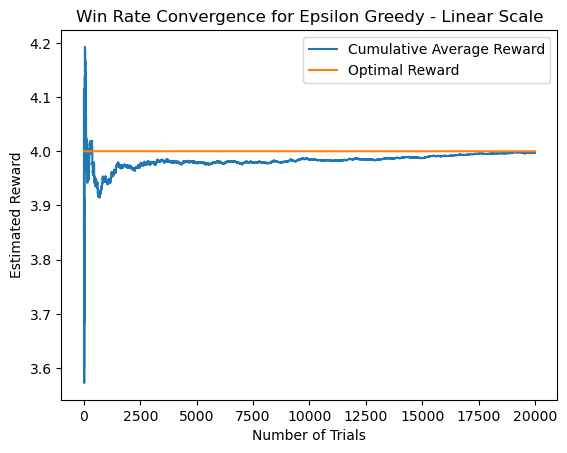

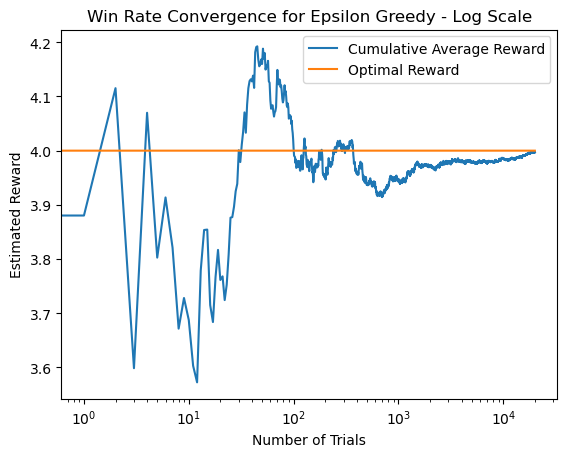

In [5]:
Visualization().plot1(NumberOfTrials, res, 'Epsilon Greedy')

# Thomspson Sampling

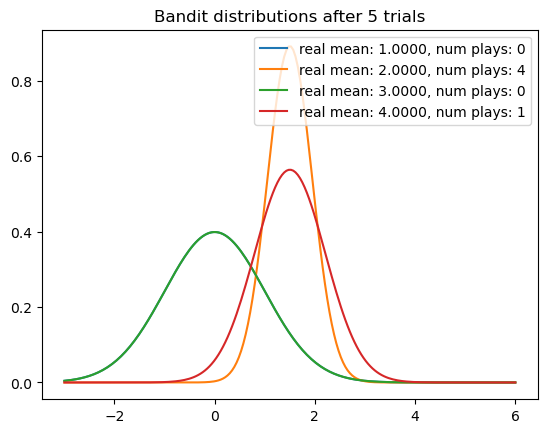

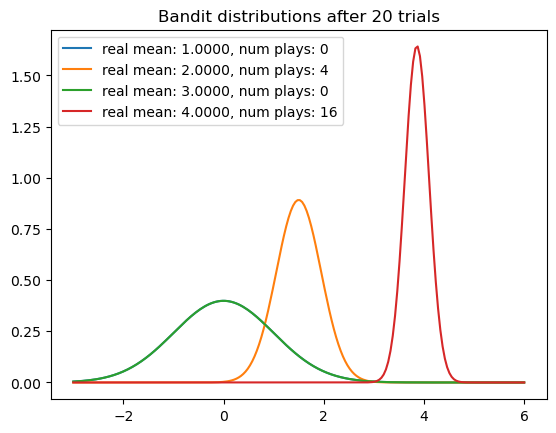

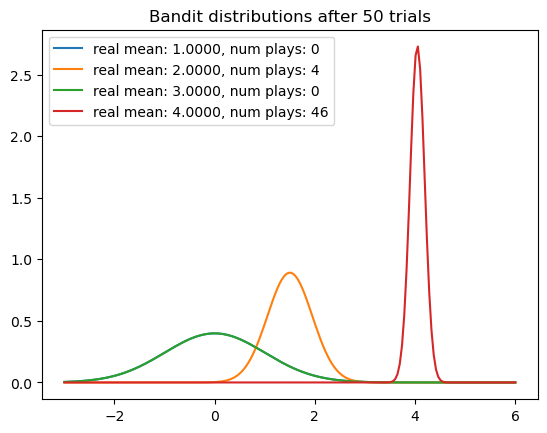

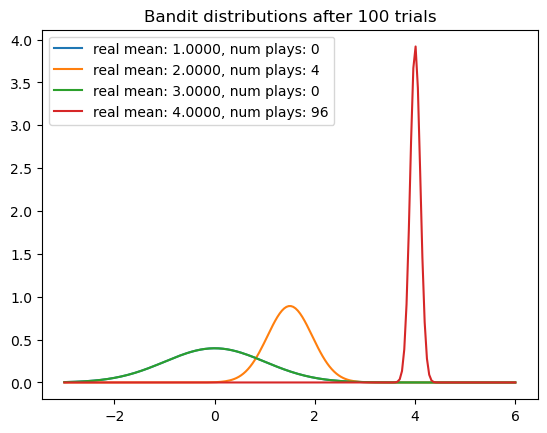

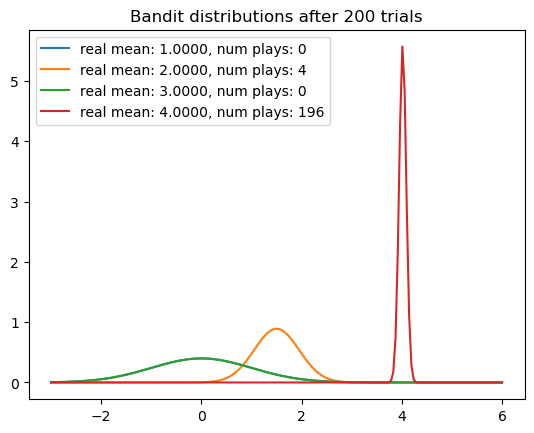

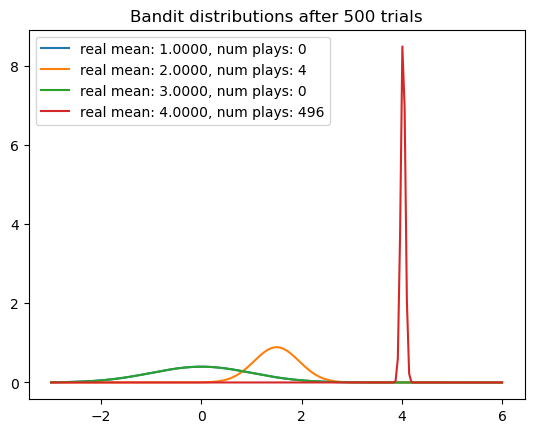

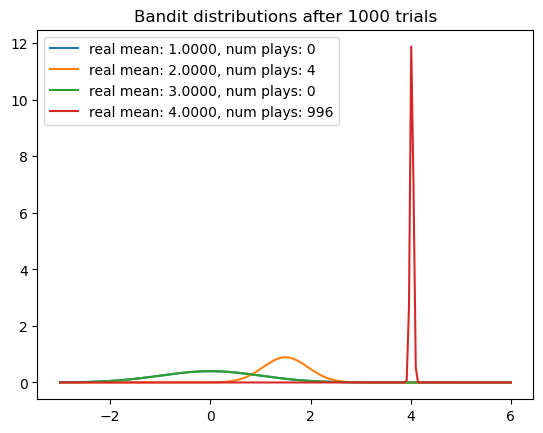

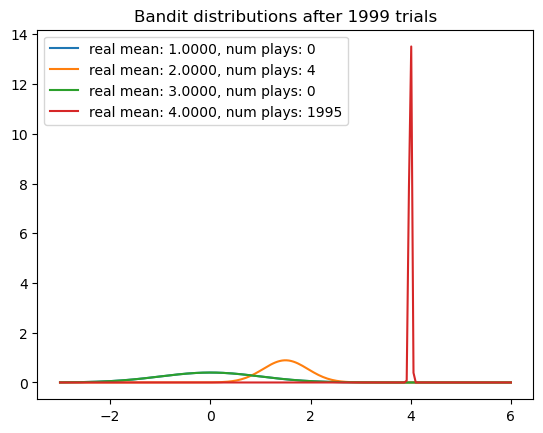

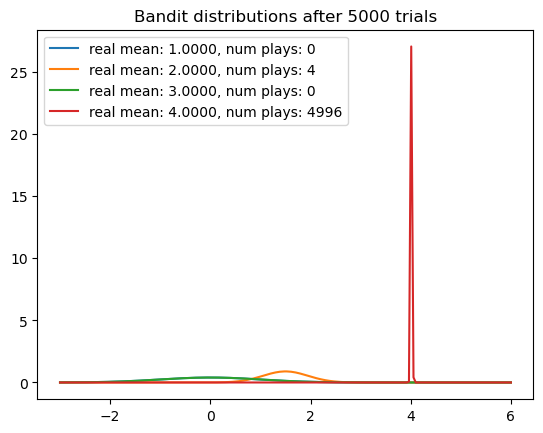

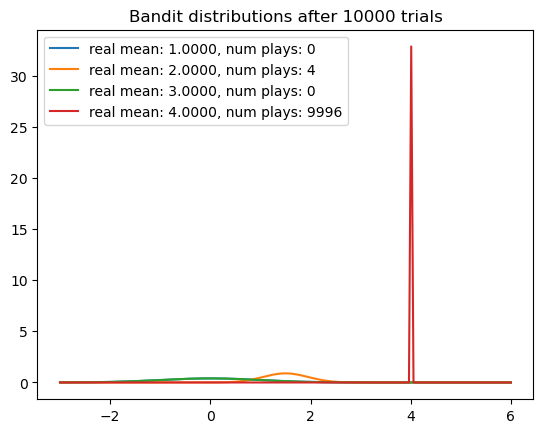

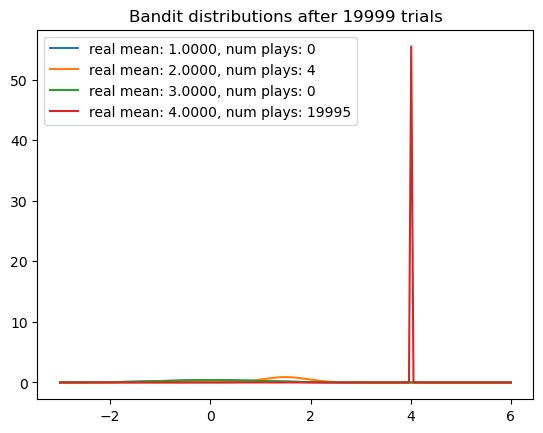

In [6]:
TS = ThompsonSampling(Bandit).experiment(Bandit_Reward, NumberOfTrials)

In [7]:
ThompsonSampling(Bandit).report(NumberOfTrials, TS, 'ThompsonSampling')

Bandit with True Win Rate 1 - Pulled 0 times - Estimated average reward - 0 - Estimated average regret - 0
Bandit with True Win Rate 2 - Pulled 4 times - Estimated average reward - 1.5004 - Estimated average regret - 0.4996
Bandit with True Win Rate 3 - Pulled 0 times - Estimated average reward - 0 - Estimated average regret - 0
Bandit with True Win Rate 4 - Pulled 19996 times - Estimated average reward - 4.0114 - Estimated average regret - -0.0114
Cumulative Reward : 80222.88394847409
 
Cumulative Regret : -222.88394847408927
 


# Visualization of Thomspson Sampling learning

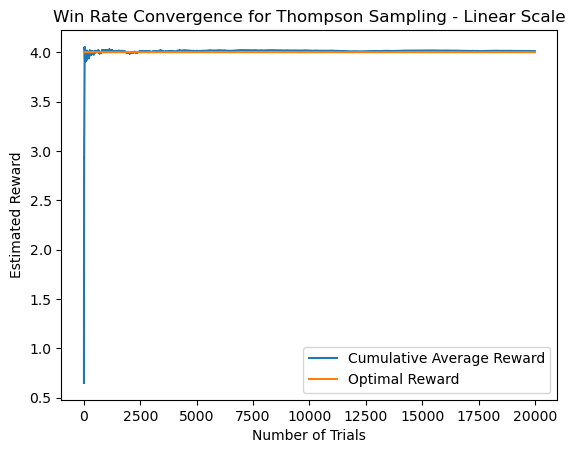

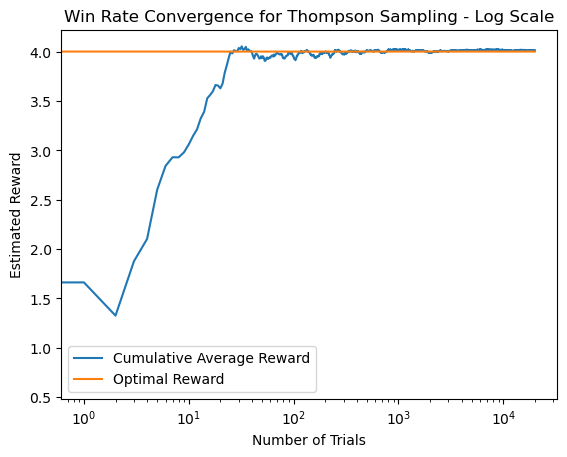

In [8]:
Visualization().plot1( NumberOfTrials,TS, algorithm ='Thompson Sampling')